In [1]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"

import itertools
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from src.api.models.pydantic import SimRoomClassDTO
from src.config import UNKNOWN_CLASS_ID
from ultralytics import YOLO

from experiment.prediction_utils import (
    calculate_metrics,
    create_confusion_matrix,
    evaluate_predictions,
    render_confusion_matrix,
    update_confusion_matrix,
)
from experiment.settings import (
    CLASS_ID_TO_NAME,
    FINAL_PREDICTIONS_PATH,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    LABELING_REC_DIFF_BACKGROUND_ID,
    LABELING_REC_SAME_BACKGROUND_ID,
    OBJECT_DATASETS_PATH,
    TRAINING_DATASETS_PATH,
    YOLO_MODELS_PATH,
    SIMROOM_ID,
    RECORDINGS_PATH,
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service
import cv2
import numpy as np
import tempfile
from src.utils import extract_frames_to_dir
import albumentations as A
from tqdm import tqdm

%matplotlib inline

# Create Training Data

In [2]:
IMG_CROP_SIZE = 640
IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2
TOP_N_RESULTS = 2000
OBJECT_DETECTION_DATASETS_PATH = TRAINING_DATASETS_PATH / "object_detection"

if OBJECT_DATASETS_PATH.exists():
    shutil.rmtree(OBJECT_DATASETS_PATH)
OBJECT_DETECTION_DATASETS_PATH.mkdir(parents=True, exist_ok=True)

TRAIN_IMAGES_PATH = OBJECT_DETECTION_DATASETS_PATH / "images" / "train"
TRAIN_IMAGES_PATH.mkdir(parents=True, exist_ok=True)
VAL_IMAGES_PATH = OBJECT_DETECTION_DATASETS_PATH / "images" / "val"
VAL_IMAGES_PATH.mkdir(parents=True, exist_ok=True)
TRAIN_LABELS_PATH = OBJECT_DETECTION_DATASETS_PATH / "labels" / "train"
TRAIN_LABELS_PATH.mkdir(parents=True, exist_ok=True)
VAL_LABELS_PATH = OBJECT_DETECTION_DATASETS_PATH / "labels" / "val"
VAL_LABELS_PATH.mkdir(parents=True, exist_ok=True)
DATA_YML_PATH = OBJECT_DETECTION_DATASETS_PATH / "data.yaml"



In [3]:
def get_tracking_results_per_class(session: Session, labeling_recording_id: str):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id=labeling_recording_id
    ).id
    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    if len(tracked_classes) != 15:
        raise ValueError(f"Expected 15 tracked classes but got {len(tracked_classes)}")

    tracking_results_per_class = {
        tracked_class.id: simrooms_repo.get_tracking_result_paths(
            session, calibration_id, tracked_class.id
        )
        for tracked_class in tracked_classes
    }

    return tracking_results_per_class, tracked_classes

In [4]:
def select_samples_per_class(tracking_results_per_class):
    selected_results_per_class = {
        tracked_class_id: []
        for tracked_class_id in tracking_results_per_class.keys()
    }

    for tracked_class_id, tracking_results in tracking_results_per_class.items():
        result_mask_ares = []
        for tracking_result in tracking_results:
            file = np.load(tracking_result)
            mask = file["mask"]
            mask_area = np.sum(mask)
            result_mask_ares.append(mask_area)

        # now sort tracking results by mask area
        sorted_results = sorted(
            zip(tracking_results, result_mask_ares), key=lambda x: x[1], reverse=True
        )

        # now plot the mask areas (sorted by area)
        result_mask_ares = [x[1] for x in sorted_results]
        tracking_results = [x[0] for x in sorted_results]
        # plt.plot(result_mask_ares)
        # plt.title(f"Class {CLASS_ID_TO_NAME[tracked_class_id]}")
        # plt.xlabel("Tracking result index")
        # plt.ylabel("Mask area")
        # plt.show()

        # select top N results
        if len(tracking_results) < TOP_N_RESULTS:
            # ignore the class
            print(
                f"Class {CLASS_ID_TO_NAME[tracked_class_id]} has only {len(tracking_results)} results, ignoring it"
            )
            continue

        selected_results = tracking_results[:TOP_N_RESULTS]
        selected_results_per_class[tracked_class_id] = selected_results
    
    return selected_results_per_class

def prepare_data_params(
    session: Session, labeling_recording_id: str
):
    tracking_results_per_class, tracked_classes = get_tracking_results_per_class(
        session, labeling_recording_id
    )

    labeled_boxes_per_frame = {}
    for class_id, tracking_results in tracking_results_per_class.items():
        for tracking_result in tracking_results:
            file = np.load(tracking_result)
            frame_idx = int(tracking_result.stem)
            
            if labeled_boxes_per_frame.get(frame_idx) is None:
                labeled_boxes_per_frame[frame_idx] = []

            labeled_boxes_per_frame[frame_idx].append(
                (class_id, file["box"])
            )

    print("Selecting samples per class")
    selected_results_per_class = select_samples_per_class(tracking_results_per_class)

    selected_samples_per_frame = {}
    for class_id, tracking_results in selected_results_per_class.items():
        for tracking_result in tracking_results:
            file = np.load(tracking_result)
            frame_idx = int(tracking_result.stem)

            if selected_samples_per_frame.get(frame_idx) is None:
                selected_samples_per_frame[frame_idx] = []

            selected_samples_per_frame[frame_idx].append(
                (class_id, file["box"])
            )

    print(f"Extracting frames for {labeling_recording_id}")
    video_path = RECORDINGS_PATH / f"{labeling_recording_id}.mp4"
    tmp_frames_dir = tempfile.TemporaryDirectory()
    tmp_frames_path = Path(tmp_frames_dir.name)
    extract_frames_to_dir(
        video_path=video_path,
        frames_path=tmp_frames_path,
        print_output=False,
    )

    return selected_samples_per_frame, labeled_boxes_per_frame, tmp_frames_dir


In [5]:
with Session(engine) as session:
    selected_samples_per_frame, labeled_boxes_per_frame, tmp_frames_dir = prepare_data_params(session, LABELING_REC_SAME_BACKGROUND_ID)
    tmp_frames_path = Path(tmp_frames_dir.name)
    frames = sorted(list(tmp_frames_path.glob("*.jpg")), key=lambda x: int(x.stem))


Selecting samples per class
Class infuus has only 786 results, ignoring it
Class ampulevloeistof has only 648 results, ignoring it
Class ampulepoeder has only 1116 results, ignoring it
Extracting frames for d6fd0aed-b901-4863-bad8-7910dad693e0


In [6]:
def draw_bboxes(image_np, bboxes, labels, class_name_map=None, color=(0, 255, 0), thickness=2):
    img_res = image_np.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1

    if not isinstance(bboxes, (list, np.ndarray)):
        print(f"Warning: bboxes is not a list or ndarray: {type(bboxes)}")
        return img_res
    if not isinstance(labels, (list, np.ndarray)):
        print(f"Warning: labels is not a list or ndarray: {type(labels)}")
        # Attempt to proceed if labels seem usable, otherwise return
        if len(bboxes) != len(labels):
            print("Warning: bbox and label length mismatch, cannot draw labels.")
            labels = ['?' for _ in bboxes] # Placeholder
        elif not all(isinstance(l, (str, int, float)) for l in labels):
             print("Warning: labels contain non-primitive types, cannot draw reliably.")
             labels = ['?' for _ in bboxes]

    for bbox, label in zip(bboxes, labels):
        # Assuming bbox format allows direct conversion to int x_min, y_min, x_max, y_max
        # This might need adjustment based on the ACTUAL format in your bboxes list
        # Example for pascal_voc or albumentations (after denormalizing)
        try:
             # Check if bbox has at least 4 elements
            if len(bbox) < 4:
                print(f"Warning: Skipping invalid bbox (fewer than 4 coords): {bbox}")
                continue
            x_min, y_min, x_max, y_max = map(int, bbox[:4])
        except (ValueError, TypeError) as e:
            print(f"Warning: Could not convert bbox coords to int: {bbox}, Error: {e}")
            continue # Skip this bbox

        cv2.rectangle(img_res, (x_min, y_min), (x_max, y_max), color, thickness)

        label_name = str(label) if class_name_map is None else class_name_map.get(label, str(label))
        # Simple text placement above the box
        (text_width, text_height), baseline = cv2.getTextSize(label_name, font, font_scale, font_thickness)
        text_y = y_min - baseline if y_min - baseline > text_height else y_min + text_height
        cv2.putText(img_res, label_name, (x_min, text_y), font, font_scale, color, font_thickness)

    return img_res

In [31]:
train_transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(width=IMG_CROP_SIZE, height=IMG_CROP_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['class_labels'],
    min_visibility=0.7
))

def create_training_data(selected_samples_per_frame, labeled_boxes_per_frame, frames):
    done = 0

    for frame_idx, frame in tqdm(enumerate(frames)):
        image = cv2.imread(str(frame))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        print(labeled_boxes_per_frame.get(frame_idx))
        if labeled_boxes_per_frame.get(frame_idx) is None:
            continue

        # gather boxes and labels for the current frame
        bboxes = []
        class_ids = []
        for class_id, box in labeled_boxes_per_frame[frame_idx]:
            bboxes.append(box)
            class_ids.append(class_id)
        bboxes = np.array(bboxes)

        # for all selected samples in this frame, create crops
        for class_id, box in selected_samples_per_frame[frame_idx]:
            x1, y1, x2, y2 = box
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

            # create a crop around the center of the box
            x_min = max(0, cx - IMG_CROP_SIZE_HALF)
            y_min = max(0, cy - IMG_CROP_SIZE_HALF)
            x_max = min(image.shape[1], cx + IMG_CROP_SIZE_HALF)
            y_max = min(image.shape[0], cy + IMG_CROP_SIZE_HALF)

            train_transform = A.Compose([
                A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
                A.PadIfNeeded(min_height=IMG_CROP_SIZE, min_width=IMG_CROP_SIZE),
                A.HorizontalFlip(p=0.5),
                # A.RandomBrightnessContrast(p=0.2)
            ], bbox_params=A.BboxParams(
                format='pascal_voc',
                label_fields=['class_labels'],
                min_visibility=0.7
            ))

            # Augment the image and boxes
            augmented = train_transform(image=image, bboxes=bboxes, class_labels=class_ids)
            transformed_image = augmented['image']
            transformed_bboxes = augmented['bboxes']
            transformed_class_ids = augmented['class_labels']

            # draw and save the augmented image for visualisation
            augmented_drawn = draw_bboxes(transformed_image, transformed_bboxes, transformed_class_ids)
            augmented_drawn = cv2.cvtColor(augmented_drawn, cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(f"data/random/{frame_idx}_{class_id}.png"), augmented_drawn)

            done += 1

        if done >= 10:
            break


In [32]:
create_training_data(
    selected_samples_per_frame,
    labeled_boxes_per_frame,
    frames,
)

20it [00:00, 189.63it/s]

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


60it [00:00, 192.92it/s]

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


103it [00:00, 173.72it/s]

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
[(9, array([1850,  207, 1919,  334], dtype=int32)), (12, array([1727,  359, 1919,  549], dtype=int32))]
[(9, array([1660,  216, 1802,  335], dtype=int32)), (12, array([1581,  362, 1814,  533], dtype=int32))]
[(8, array([1782,  136, 1911,  183], dtype=int32)), (9, array([1532,  230, 1654,  343], dtype=int32)), (12, array([1471,  369, 1681,  526], dtype=int32))]
[(8, array([1664,  149, 1778,  195], dtype=int32)), (9, array([1441,  246, 1543,  352], dtype=int32)), (12, array([1393,  380, 1578,  525], dtype=int32))]
[(8, array([1574,  165, 1675,  207], dtype=int32)), (9, array([1371,  260, 1462,  360], dtype=int32)), (12, array([1335,  389, 1503,  530], dtype=int32))]
[(8, array([1508,  178, 1599,  218], dtype=int32)), (9, array([1318,  270, 1401,  368], dtype=int32)), (12, array([1288,  397, 1446,  535], dtype=int32))]


In [47]:
frame_indexes = []
laplacian_vars = []

for frame in tqdm(frames):
    frame_idx = int(frame.stem)

    image = cv2.imread(str(frame))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    frame_indexes.append(frame_idx)
    laplacian_vars.append(laplacian_var)

100%|██████████| 14121/14121 [07:28<00:00, 31.51it/s]


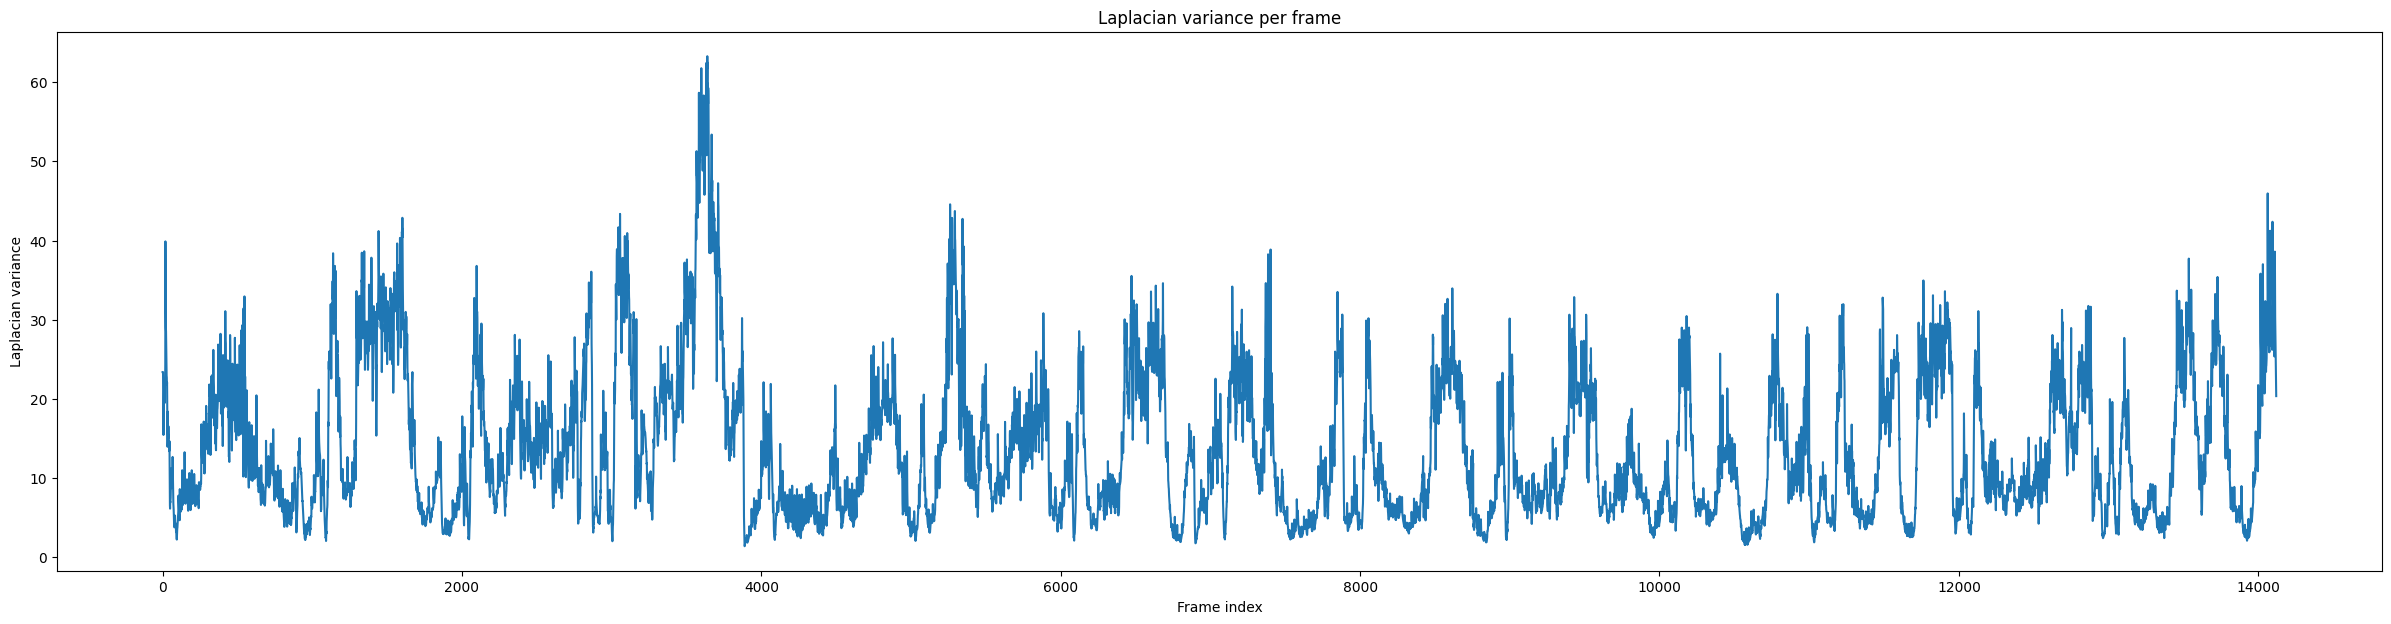

In [48]:
plt.figure(figsize=(30, 7))
plt.plot(frame_indexes, laplacian_vars)
plt.title("Laplacian variance per frame")
plt.xlabel("Frame index")
plt.ylabel("Laplacian variance")
plt.show()


Highest laplacian variance: 63.28013108130062 at frame 3639


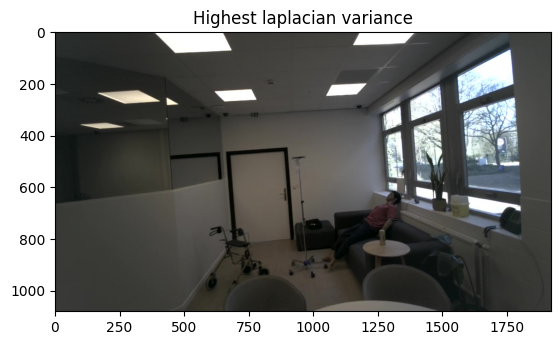

Lowest laplacian variance: 1.3814453124751664 at frame 3888


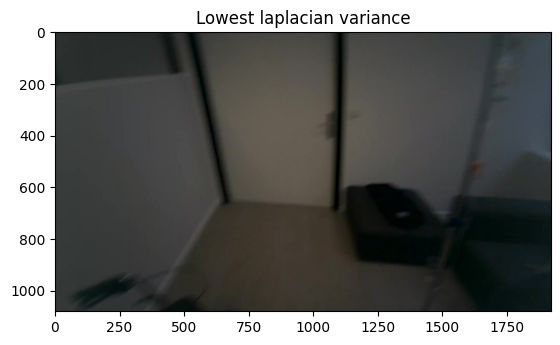

In [49]:
highest_laplacian_var = max(laplacian_vars)
highest_laplacian_var_idx = laplacian_vars.index(highest_laplacian_var)

lowest_laplacian_var = min(laplacian_vars)
lowest_laplacian_var_idx = laplacian_vars.index(lowest_laplacian_var)

print(f"Highest laplacian variance: {highest_laplacian_var} at frame {highest_laplacian_var_idx}")

image = cv2.imread(str(frames[highest_laplacian_var_idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("Highest laplacian variance")
plt.show()

print(f"Lowest laplacian variance: {lowest_laplacian_var} at frame {lowest_laplacian_var_idx}")
image = cv2.imread(str(frames[lowest_laplacian_var_idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("Lowest laplacian variance")
plt.show()
